#### Load all stocks data and calculate the average price for each stock

In [7]:
import pandas as pd

DATA_DIR = "./../data"
df = pd.read_parquet(f"{DATA_DIR}/data_frame/stock_data.parquet")
print(f"Number of rows in Parquet file: {len(df)}")

Number of rows in Parquet file: 4232710


In [21]:
# show when was stock_splits
df = df.sort_values(by="Date")

stock_splits = df[df["Stock_Splits"] != 0]
print(f"Number of stock splits: {len(stock_splits)}")

# print df firs 2 lines
print(df.head(2))

Number of stock splits: 1528
        Ticker                       Date     Open      High       Low  \
0          MMM  1962-01-02 00:00:00-05:00  0.00000  0.587004  0.569739   
1993526    HPQ  1962-01-02 00:00:00-05:00  0.04441  0.044410  0.042009   

            Close   Volume  Dividends  Stock_Splits  
0        0.574055   254509        0.0           0.0  
1993526  0.042009  2480333        0.0           0.0  


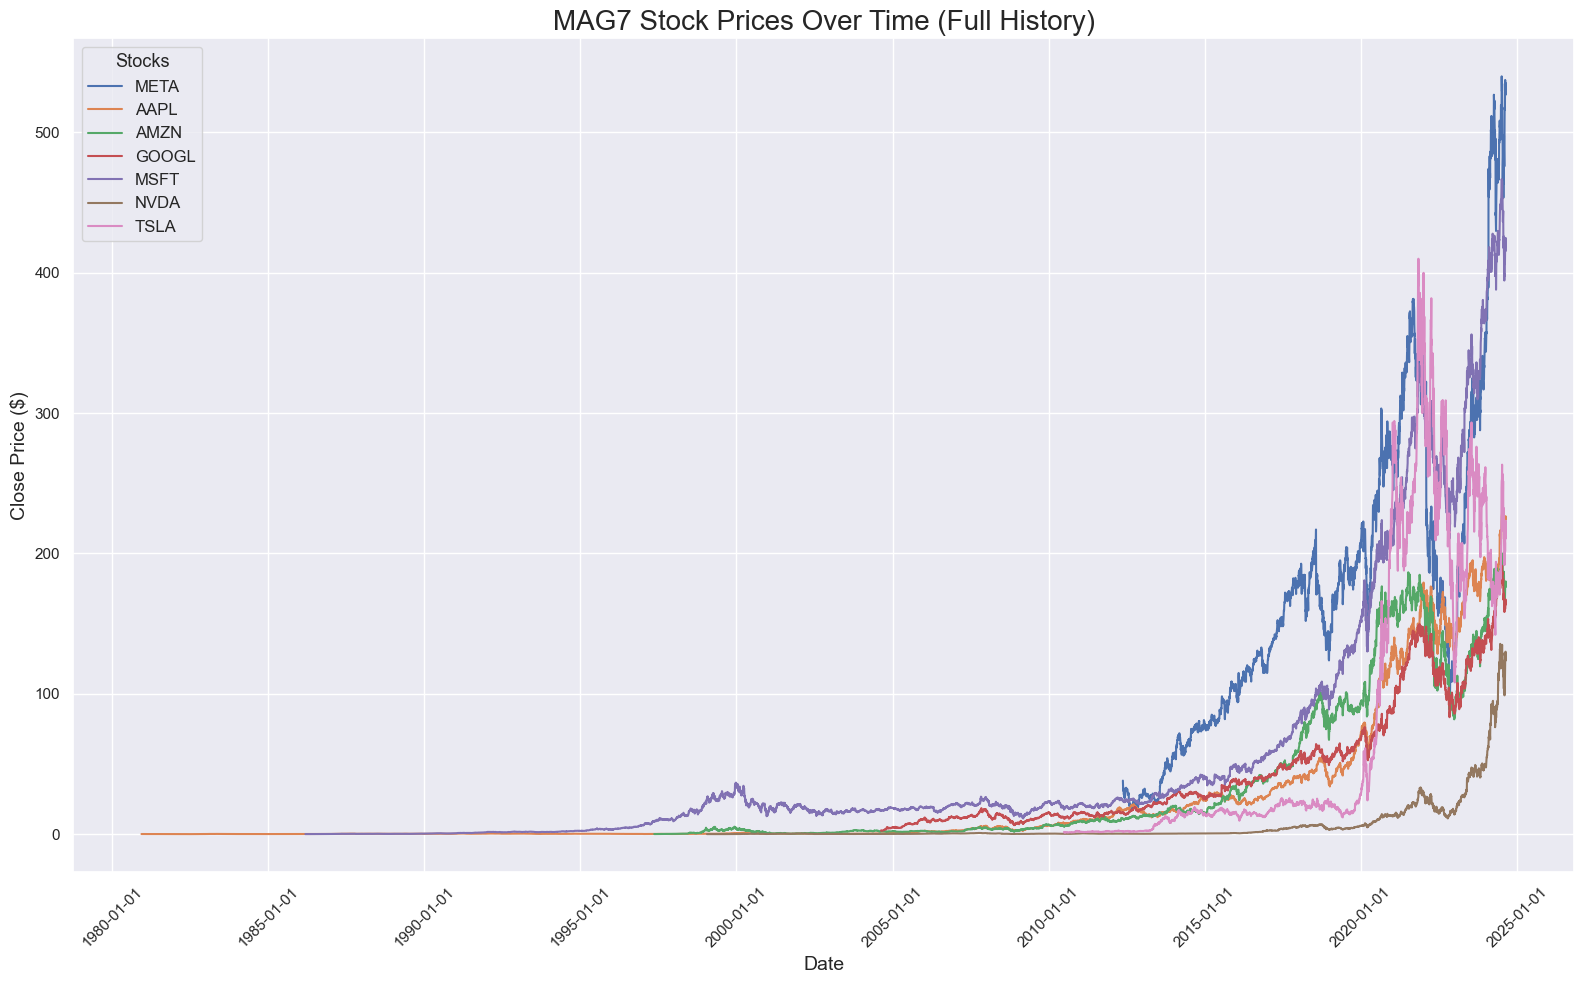

          count        mean         std        min        25%         50%  \
Ticker                                                                      
AAPL    11015.0   21.799813   46.185031   0.037856   0.242166    0.433894   
AMZN     6863.0   37.685859   54.083597   0.069792   2.080750    8.685500   
GOOGL    5037.0   45.666917   43.421404   2.499884  13.117579   27.620953   
META     3085.0  174.010419  113.615053  17.693642  83.129181  162.526031   
MSFT     9689.0   53.349436   91.234716   0.055665   3.521329   19.173788   
NVDA     6438.0    6.467435   17.041130   0.031291   0.254320    0.428685   
TSLA     3562.0   76.126834  102.631107   1.053333  11.680500   17.474667   

               75%         max  
Ticker                          
AAPL     17.346673  234.548523  
AMZN     52.469999  200.000000  
GOOGL    60.719814  191.179993  
META    223.969757  539.909973  
MSFT     38.549381  466.718781  
NVDA      4.186754  135.580002  
TSLA    166.289173  409.970001  
META pric

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assume 'df' is your existing DataFrame
# Define MAG7 stocks
mag7_tickers = ['META', 'AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA', 'TSLA']

# Filter the DataFrame for MAG7 stocks
df_mag7 = df[df['Ticker'].isin(mag7_tickers)].copy()

# Convert 'Date' to datetime with UTC=True
df_mag7['Date'] = pd.to_datetime(df_mag7['Date'], utc=True, errors='coerce')

# Drop any rows where date conversion failed
df_mag7 = df_mag7.dropna(subset=['Date'])

# Create the plot
plt.figure(figsize=(16, 10))
sns.set_style("darkgrid")

# Plot each stock separately to handle different date ranges
for ticker in mag7_tickers:
    stock_data = df_mag7[df_mag7['Ticker'] == ticker].sort_values('Date')
    plt.plot(stock_data['Date'], stock_data['Close'], label=ticker)

plt.title('MAG7 Stock Prices Over Time (Full History)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price ($)', fontsize=14)
plt.legend(title='Stocks', title_fontsize='13', fontsize='12')

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # Show a tick every 5 years
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Print some summary statistics
print(df_mag7.groupby('Ticker')['Close'].describe())

# Calculate and print the total percentage change for each stock
for ticker in mag7_tickers:
    stock_data = df_mag7[df_mag7['Ticker'] == ticker].sort_values('Date')
    if not stock_data.empty:
        initial_price = stock_data['Close'].iloc[0]
        final_price = stock_data['Close'].iloc[-1]
        percent_change = ((final_price - initial_price) / initial_price) * 100
        date_range = f"{stock_data['Date'].min().strftime('%Y-%m-%d')} to {stock_data['Date'].max().strftime('%Y-%m-%d')}"
        print(f"{ticker} price change from {date_range}: {percent_change:.2f}%")
    else:
        print(f"No data available for {ticker}")

# Optional: Print the date range for each stock
for ticker in mag7_tickers:
    stock_data = df_mag7[df_mag7['Ticker'] == ticker]
    if not stock_data.empty:
        print(f"{ticker} data range: {stock_data['Date'].min().strftime('%Y-%m-%d')} to {stock_data['Date'].max().strftime('%Y-%m-%d')}")
    else:
        print(f"No data available for {ticker}")

In [49]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, CustomJS, MultiChoice, DatePicker
from bokeh.layouts import column, row
from bokeh.palettes import Category10
from bokeh.io import output_notebook

# Ensure Bokeh outputs to notebook
output_notebook()

# Define MAG7 stocks
mag7_tickers = ['META', 'AAPL', 'AMZN', 'GOOGL', 'MSFT', 'NVDA', 'TSLA']

# Filter the DataFrame for MAG7 stocks
df_mag7 = df[df['Ticker'].isin(mag7_tickers)].copy()

# Convert 'Date' to datetime with UTC=True
df_mag7['Date'] = pd.to_datetime(df_mag7['Date'], utc=True, errors='coerce')

# Drop any rows where date conversion failed
df_mag7 = df_mag7.dropna(subset=['Date'])

# Get the overall date range
min_date = df_mag7['Date'].min().date()
max_date = df_mag7['Date'].max().date()

# Create a color map for the stocks
colors = dict(zip(mag7_tickers, Category10[10][:len(mag7_tickers)]))

# Create ColumnDataSource for each stock
sources = {ticker: ColumnDataSource(df_mag7[df_mag7['Ticker'] == ticker]) for ticker in mag7_tickers}

# Create the plot with log scale
p = figure(width=900, height=600, x_axis_type='datetime', y_axis_type='log',
           title='MAG7 Stock Prices Over Time (Log Scale)')
p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Close Price ($) - Log Scale'

# Add a line for each stock
lines = {}
for ticker in mag7_tickers:
    lines[ticker] = p.line(x='Date', y='Close', source=sources[ticker], line_color=colors[ticker], line_width=2, legend_label=ticker)

# Add hover tool
hover = HoverTool(tooltips=[('Date', '@Date{%F}'), ('Close', '@Close{0.2f}')], formatters={'@Date': 'datetime'})
p.add_tools(hover)

# Customize legend
p.legend.click_policy = 'hide'  # Clicking on legend will hide/show the line
p.legend.location = 'top_left'

# Create MultiChoice widget for choosing stocks
ticker_select = MultiChoice(title='Select Stocks:', value=mag7_tickers, options=mag7_tickers)

# Create DatePicker widgets for start and end dates
date_picker_start = DatePicker(title='Start Date', value=min_date, min_date=min_date, max_date=max_date)
date_picker_end = DatePicker(title='End Date', value=max_date, min_date=min_date, max_date=max_date)

# JavaScript callback for updating the plot
callback = CustomJS(args=dict(p=p, lines=lines, ticker_select=ticker_select,
                              date_picker_start=date_picker_start, date_picker_end=date_picker_end,
                              sources=sources), code="""
    const selected_tickers = ticker_select.value;
    const start_date = new Date(date_picker_start.value).getTime();
    const end_date = new Date(date_picker_end.value).getTime();
    
    let min_price = Infinity;
    let max_price = -Infinity;
    
    for (let ticker in sources) {
        const source = sources[ticker];
        const original_data = source.data;
        const new_data = {Date: [], Close: []};
        
        for (let i = 0; i < original_data.Date.length; i++) {
            const date = new Date(original_data.Date[i]).getTime();
            if (date >= start_date && date <= end_date) {
                new_data.Date.push(original_data.Date[i]);
                new_data.Close.push(original_data.Close[i]);
                
                if (original_data.Close[i] < min_price) min_price = original_data.Close[i];
                if (original_data.Close[i] > max_price) max_price = original_data.Close[i];
            }
        }
        
        source.data = new_data;
        lines[ticker].visible = selected_tickers.includes(ticker);
    }
    
    p.y_range.start = Math.max(0.1, min_price * 0.9);
    p.y_range.end = max_price * 1.1;
    
    p.x_range.start = date_picker_start.value;
    p.x_range.end = date_picker_end.value;
    
    p.change.emit();
""")

ticker_select.js_on_change('value', callback)
date_picker_start.js_on_change('value', callback)
date_picker_end.js_on_change('value', callback)

# Show the plot
layout = column(
    ticker_select,
    row(date_picker_start, date_picker_end),
    p
)
show(layout)

Loading BokehJS ...